In [1]:
from link_generation.models.curiousity_models import GNN
from link_generation.predicting_signature.utils import remove_cancelations, get_knot_graph_dataloader
import torch 
import matplotlib.pyplot as plt 
import numpy as np

/home/nattd/.conda/envs/knotenv/lib/python3.11/site-packages/snappy/pari.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version


In [2]:
model = GNN.load_from_checkpoint('../../../logs/kno_nheads8_nlayers5/version_37/checkpoints/epoch=42-step=21844.ckpt', hidden_channels=32, num_heads=8, both=False, k=1, map_location=torch.device('cpu'))

In [3]:
val_braids = remove_cancelations('val')
val_targets = np.load('y_val.npy')
val_loader = get_knot_graph_dataloader(val_braids, val_targets, both=False,
                                       pos_neg=False, ohe_inverses=True, 
                                       undirected=True, laplacian=False,
                                       k=1, batch_size=128, shuffle=False)

/home/nattd/repos/link-generation/src/link_generation/predicting_signature/utils.py:193: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1724789121465/work/aten/src/ATen/native/Copy.cpp:305.)
  node_features[:,:k] = get_laplacian_positional_ecoding(edges, k, len(braid_word))


In [36]:
actual_sig = []
predicted_sig = []
knots = []
for i, batch in enumerate(val_loader) :
    actual_sig.extend(list(batch.y.numpy()))
    predicted_sig.extend(list(model(batch).squeeze(1).detach().numpy()))
    for i in np.arange(128)[np.abs(np.array(actual_sig[-128:]) - np.array(predicted_sig[-128:])) > 4] :
        nodes = np.arange(len(batch.batch))[batch.batch == i]
        knots.append(batch.x[nodes,:])
    if i >= 4 : 
        break

In [37]:
braids = []
for knot in knots : 
    braid_word = []
    for node in knot[:,1:] :
        for i, ohe in enumerate(node) :
            if ohe.item() == 1 :
                braid_word.append((1-2*(i//6))*(i+1) + (i//6)*6)
    braids.append(braid_word)
braids

[[-6,
  -6,
  -3,
  -3,
  1,
  -3,
  -2,
  -2,
  -2,
  -2,
  -2,
  -2,
  3,
  -2,
  -2,
  -2,
  -2,
  -5,
  -2,
  -2,
  6,
  -3,
  -1,
  -3,
  -4,
  -4,
  -1,
  -1,
  -1,
  -1,
  -2,
  -3,
  -5,
  -5,
  -6,
  -6],
 [6, 6, 6, 1, 4, 6, 6, 6, 4, 4, 4, 3, 6, 6, -1, 6, 3, -1]]

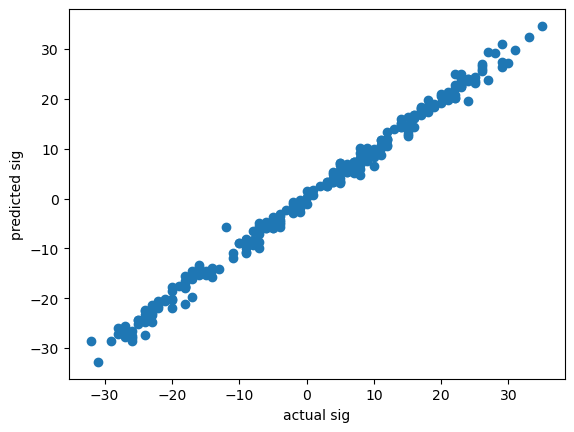

In [38]:
plt.scatter(actual_sig, predicted_sig)
plt.xlabel('actual sig')
plt.ylabel('predicted sig')
plt.show()

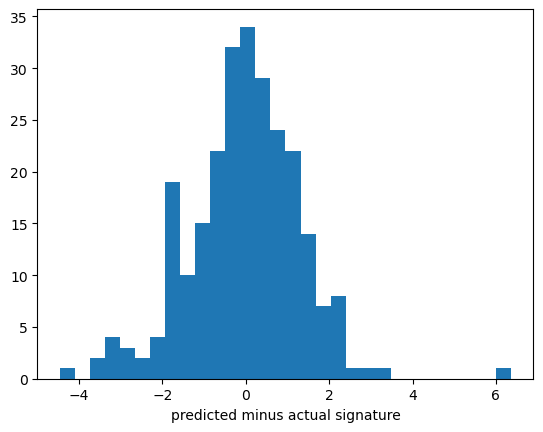

In [39]:
plt.hist(np.array(predicted_sig) - np.array(actual_sig), bins=30)
plt.xlabel('predicted minus actual signature')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sig = np.load('y_train.npy')
det = np.load('det_train.npy')

In [5]:
import json
with open('train_braids.txt', 'r') as f :
    braids = json.load(f)

In [3]:
print(np.min(sig), np.max(sig))
print(np.min(np.log1p(det)), np.max(np.log1p(det)))

-37.0 37.0
0.0 14.896191367645818


/tmp/ipykernel_294189/3200006334.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(sig, np.log(det))


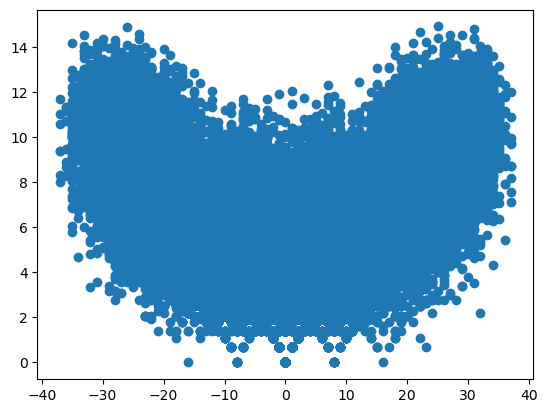

In [5]:
plt.scatter(sig, np.log(det))
plt.show()

In [6]:
from sage.all import BraidGroup, Link, Integer

In [46]:
word = np.random.choice([i for i in range(-6,7) if i != 0], size=10)
word = [Integer(i) for i in word]
B = BraidGroup(7)
np.log1p(Link(B(word)).determinant())

2.5649493574615367

In [7]:
idx = []
B = BraidGroup(7)
for i, braid in enumerate(braids) :
    if Link(B([Integer(sig) for sig in braid])).is_knot() :
        idx.append(i)

In [8]:
print(np.min(sig[idx]), np.max(sig[idx]))
print(np.min(np.log1p(det[idx])), np.max(np.log1p(det[idx])))

-34.0 34.0
0.6931471805599453 14.052924599739683


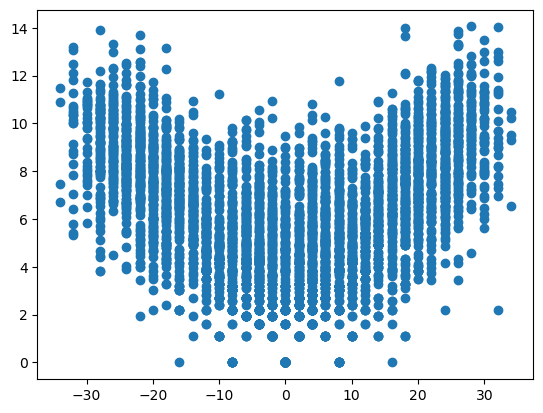

In [9]:
plt.scatter(sig[idx], np.log(det[idx]))
plt.show()

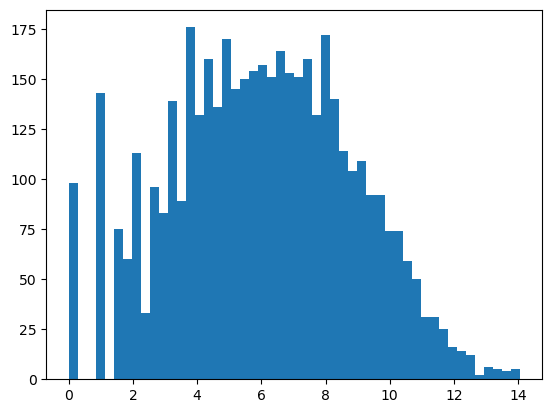

In [11]:
plt.hist(np.log(det[idx]), bins=50)
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
type(scaler)

sklearn.preprocessing._data.StandardScaler